In [2]:
import os
import numpy as np
import cv2
import pandas as pd
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [3]:
# Load VGG19 model (Extract features from block5_conv4 layer)
base_model = VGG19(weights='imagenet')
feature_model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_conv4').output)

In [6]:
# Dataset Path
dataset_path = "D:/Projects/Mini Project/Face Recognition System/archive_new/faces"
categories = ["man", "women"]

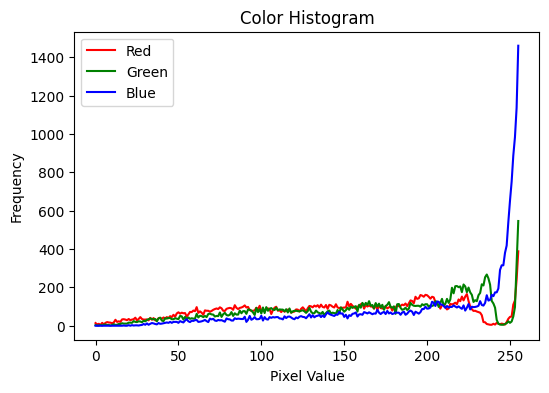

In [14]:
# 1. Color Histogram (RGB)
def color_histogram(image):
    hist_r = cv2.calcHist([image], [0], None, [256], [0, 256])
    hist_g = cv2.calcHist([image], [1], None, [256], [0, 256])
    hist_b = cv2.calcHist([image], [2], None, [256], [0, 256])
    hist = np.concatenate([hist_r, hist_g, hist_b]).flatten()

    # Plot histograms
    plt.figure(figsize=(6, 4))
    plt.plot(hist_r, color='red', label='Red')
    plt.plot(hist_g, color='green', label='Green')
    plt.plot(hist_b, color='blue', label='Blue')
    plt.title('Color Histogram')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    return hist

color_hist = color_histogram(cv2.imread(image_path))  # Shape: (768,)

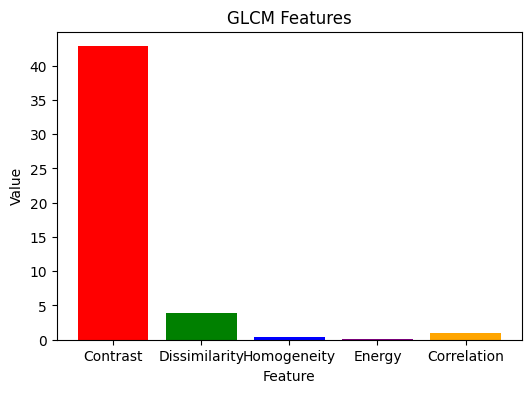

In [16]:
# 2. Gray Level Co-occurrence Matrix (GLCM) Features
def glcm_features(gray_image):
    glcm = graycomatrix(gray_image, distances=[1], angles=[0], symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    features = np.array([contrast, dissimilarity, homogeneity, energy, correlation])

    # Plot GLCM features
    labels = ['Contrast', 'Dissimilarity', 'Homogeneity', 'Energy', 'Correlation']
    plt.figure(figsize=(6, 4))
    plt.bar(labels, features, color=['red', 'green', 'blue', 'purple', 'orange'])
    plt.title('GLCM Features')
    plt.xlabel('Feature')
    plt.ylabel('Value')
    plt.show()

    return features

glcm_feat = glcm_features(gray_image)  # Shape: (5,)

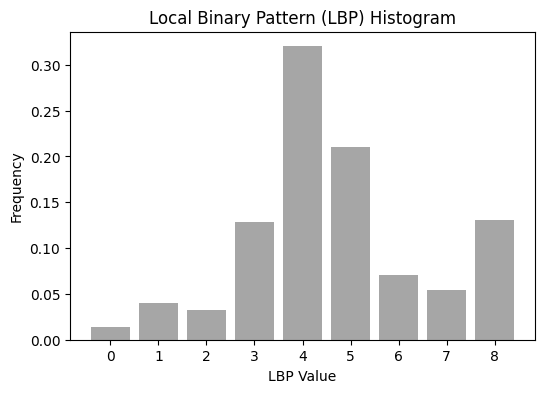

In [17]:
# 3. Local Binary Pattern (LBP) Features
def lbp_features(gray_image):
    lbp = local_binary_pattern(gray_image, P=8, R=1, method="uniform")
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 10))
    hist = hist / np.sum(hist)  # Normalize

    # Plot LBP histogram
    plt.figure(figsize=(6, 4))
    plt.bar(range(9), hist, color='gray', alpha=0.7)
    plt.title('Local Binary Pattern (LBP) Histogram')
    plt.xlabel('LBP Value')
    plt.ylabel('Frequency')
    plt.xticks(range(9))
    plt.show()

    return hist


lbp_hist = lbp_features(gray_image)  # Shape: (9,)

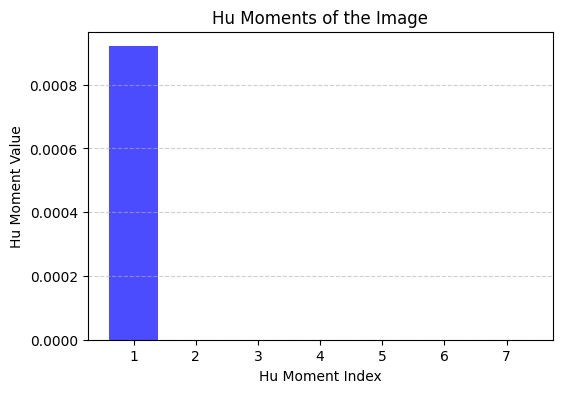

In [18]:
# 4. Hu Moments (Shape Features)
def hu_moments(gray_image):
    moments = cv2.moments(gray_image)
    hu = cv2.HuMoments(moments).flatten()

    # Plot the Hu Moments
    plt.figure(figsize=(6, 4))
    plt.bar(range(1, 8), hu_moments_feat, color='blue', alpha=0.7)
    plt.xlabel('Hu Moment Index')
    plt.ylabel('Hu Moment Value')
    plt.title('Hu Moments of the Image')
    plt.xticks(range(1, 8))
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()

    return hu

hu_moments_feat = hu_moments(gray_image)  # Shape: (7,)

In [19]:
# Initialize list to store extracted features
feature_data = []

In [ ]:
# Concatenate all features into one vector
final_feature_vector = np.concatenate([
    deep_features,  
    color_hist,     
    glcm_feat,      
    lbp_hist,       
    hu_moments_feat 
])

In [24]:
# Print feature shapes
print("Deep Features Shape:", deep_features.shape)
print("Color Histogram Shape:", color_hist.shape)
print("GLCM Features Shape:", glcm_feat.shape)
print("LBP Features Shape:", lbp_hist.shape)
print("Hu Moments Shape:", hu_moments_feat.shape)
print("Final Feature Vector Shape:", final_feature_vector.shape)

Deep Features Shape: (100352,)
Color Histogram Shape: (768,)
GLCM Features Shape: (5,)
LBP Features Shape: (9,)
Hu Moments Shape: (7,)
Final Feature Vector Shape: (101141,)


In [ ]:
# Process each category (man/woman)
for category in categories:
    category_path = os.path.join(dataset_path, category)

    for filename in os.listdir(category_path):
        image_path = os.path.join(category_path, filename)

        # Load and preprocess the image
        image = load_img(image_path, target_size=(224, 224))
        image_array = img_to_array(image)
        image_array = preprocess_input(image_array)
        image_array = image_array.reshape((1, 224, 224, 3))

        # Extract deep features
        deep_features = feature_model.predict(image_array).flatten()  # Shape: (4096,)

        # Convert image to grayscale
        gray_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        gray_image = cv2.resize(gray_image, (224, 224))

        # Extract handcrafted features
        color_hist = color_histogram(cv2.imread(image_path))  # Shape: (768,)
        glcm_feat = glcm_features(gray_image)  # Shape: (5,)
        lbp_hist = lbp_features(gray_image)  # Shape: (9,)
        hu_moments_feat = hu_moments(gray_image)  # Shape: (7,)

        # Concatenate all features
        final_feature_vector = np.concatenate([
            deep_features,  # 4096
            color_hist,     # 768
            glcm_feat,      # 5
            lbp_hist,       # 9
            hu_moments_feat # 7
        ])

        # Append to dataset
        feature_data.append([filename, category] + list(final_feature_vector))

In [25]:
print(final_feature_vector)

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  5.28844037e-25
 -1.93527389e-16 -2.77983168e-23]


In [ ]:
# Convert to DataFrame
columns = ["Filename", "Category"] + [f"F_{i}" for i in range(len(final_feature_vector))]
df = pd.DataFrame(feature_data, columns=columns)

In [ ]:
# Save to CSV
df.to_csv("features.csv", index=False)

In [ ]:
print("Feature extraction completed. Saved to features.csv.")

Feature extraction completed. Saved to features.csv.
